# Auxiliary modules

In [962]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pylab import *

import numpy as np
import itertools

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
%autosave 180


def show_gallery(images, n_rows, n_cols=10):
    '''Show photos from set
    
    Args:
        images[k,m,n]: set of k images m*n
        n_rows (int): rows to show
        n_cols (int): columns to show in each row
    '''
    images = array(images)
    n_imgs = shape(images)[0]
    n_rows = min(n_rows, int(ceil(n_imgs/n_cols)))
    grid_size = (n_rows, n_cols)
    figure(figsize=reversed(grid_size))
    
    for i,j in itertools.product(range(n_rows), range(n_cols)):
        subplot2grid(grid_size, (i, j), colspan=1, rowspan=1, aspect="auto")
        if i*n_cols+j<n_imgs:
            imshow(images[i*n_cols+j], cmap='gray', interpolation="nearest")
        xticks(())
        yticks(())
        axis("off")
        grid(False)
        
    subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    show()
    
'''HOSVD'''
# https://en.wikipedia.org/wiki/Higher-order_singular_value_decomposition

def kmul(a,b,k):
    '''Mode-k multiplication (tensor-matrix multiplication)
        rank(a) = I1 x...x Ik-1 x Ik x Ik+1 x...x IN
        rank(b) = Ik x J
        rank(a x_k b) = I1 x...x Ik-1 x J x Ik+1 x...x IN'''
    # https://en.wikipedia.org/wiki/Tensor-matrix_multiplication
    rank = list(shape(a))
    rank[k] = len(b)
    c = unflat(b.dot(flat(a,k)),rank,k)
    return c
    
def gmul(a,B):
    '''Generalized (tensor-matrix) multiplication
        (for the set of matrices B for each dimension of tensor a)'''
    c = a
    for k in range(len(shape(a))):
        c = kmul(c,B[k],k)
    return c
    
def ind(N, rank):
    '''Number in the index'''
    # Например rank = [2,3,4], N = 15
    # Тогда ind(0) = [0,0,0], ind(1) = [0,0,1]
    # ind(2) = [0,0,2], ind(4) = [0,1,0]
    # ind(5) = [0,1,1], ind(11) = [0,2,3]
    # И в конце концов, ind(N) = [1,0,3]
    I = []
    n = N
    for i in rank[::-1]:
        I = [n%i] + I
        n = int(n/i)
    return tuple(I)

def flaxis(tensor, k):
    '''Make k-th axis first'''
    # i1,i2,...,ik-1,ik,ik+1,...,iN
    # ik,i1,i2,...,ik-1,ik+1,...,iN
    k = k%len(shape(tensor))
    if k:
        return moveaxis(tensor, list(range(k+1)), [i for i in range(1,k+1)] + [0])
    else:
        return tensor
    
def kaxis(tensor, k):
    '''Make first axis k-th'''
    # ik,i1,i2,...,ik-1,ik+1,...,iN
    # i1,i2,...,ik-1,ik,ik+1,...,iN
    k = k%len(shape(tensor))
    if k:
        return moveaxis(tensor, list(range(k+1)), [k]+[i for i in range(k)])
    else:
        return tensor
    
def flat(tensor, k):
    '''tensor flatten'''
    rank = shape(tensor)
    return reshape(ravel(flaxis(tensor,k)),(rank[k],int(np.prod(rank)/rank[k])))

def unflat(flat_tensor, rank, k):
    '''MAKE TENSOR STRUCTURED AGAIN!'''
    return kaxis(concatenate(flat_tensor).reshape(flaxis(zeros(rank),k).shape),k)

def hosvd(tensor):
    '''High-Ordered Singular Value Decomposition'''
    # A = S x1 U1 x2 U2 ... xN UN
    N = len(shape(tensor))
    # Тензор A ранга I1 x I2 x...x IN
    # Тензор-матрица для k-ого измерения A(k) = Ik x (I1*...*Ik-1*Ik+1*...*IN)
    A = [flat(tensor, k) for k in range(N)]
    # A(k) = Uk*Σk*Vk, сохраняем Uk
    U = [linalg.svd(A[k], full_matrices=False)[0] for k in range(N)]
    # Тензор-ядро S = A x1 U1^T x2 U2^T ... xN UN^T
    S = gmul(tensor, [transpose(u) for u in U])
    return (S,U)

def subarr(a,d):
    if len(list(d)) > 1:
        return array([subarr(b,d[1:]) for b in a[:d[0]]])
    else:
        return a[:d[0]]

def trunc(s, U, dim, su=False):
    s_trunced = subarr(s,dim)
    U_trunced = [U[k][:,:dim[k]] for k in range(len(dim))]
    if su:
        return gmul(s_trunced, U_trunced), s_trunced, U_trunced
    else:
        return gmul(s_trunced, U_trunced)

# Тензорирование выборки
def tensoring(faces, features):
    dim1 = [len(set(array(features)[:,i])) for i in range(shape(features)[1])]
    dim2 = list(shape(faces))[1:]
    tensor = zeros(dim1+dim2)
    
    for face,f in zip(faces, features):
        tensor[tuple(f)] = face
    return tensor
    

'''Principal Component Number Estimators'''
def broken_stick(s, par=1):
    eigs = s**2
    c = sum(eigs)
    e = eigs/c
    n = len(eigs)
    l = [sum([1/j for j in range(i+1,n+1)])/n for i in range(n)]
    k = 1
    for i in range(1, n):
        if e[i] < l[i]:
            k = i
            break
    return k

def eps_rank(s, eps=1):
    k = 1
    n = len(s)
    for i in range(1, n):
        if s[i] <= eps:
            k = i
            break
    return k

def kaiser(s, alpha=0.95):
    eigs = s**2
    c = sum(eigs)
    n = len(eigs)
    k = 0
    for i in range(1, n):
        k += 1
        if sum(eigs[:i]) > alpha*c:
            break
    return k
       
PCN = {
    'Brocken Stick': lambda s, a: broken_stick(s, a),
    'Epsilon Rank': lambda s, a: eps_rank(s, a),
    'Kaiser': lambda s, a: kaiser(s, a),
    'Manual': lambda s, a: a,
    'Full': lambda s, a: len(s)
}

Autosaving every 180 seconds


# ORL dataset

In [437]:
data = fetch_olivetti_faces()
X = data.images
y = data.target

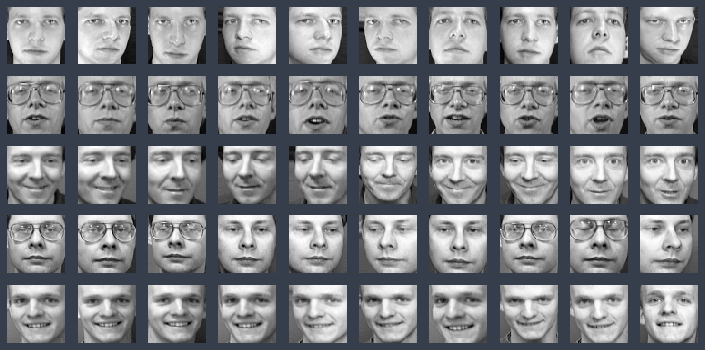

In [438]:
show_gallery(X, 5)

# HOSVD Experiments

#### Вычтем усреднение по всем координатам

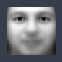

In [119]:
mean_face = average(X, axis=0)
show_gallery([mean_face], 1, 1)
F = X-mean_face

#### HOSVD-разложение

(400, 64, 64)
(400, 400)
(64, 64)
(64, 64)


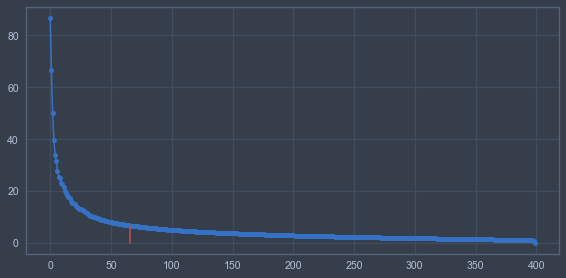

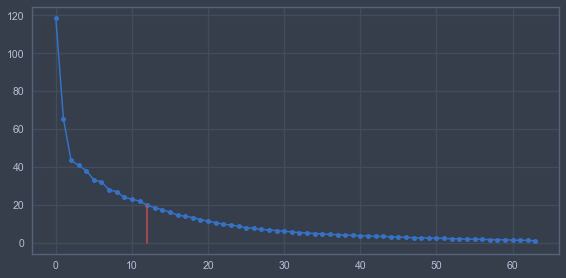

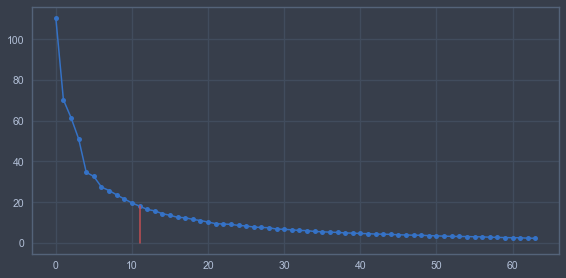

In [302]:
# Непосредственно разложение
N = len(shape(F))
A = [flat(F, k) for k in range(N)]
U = [linalg.svd(A[k], full_matrices=False)[0] for k in range(N)]
s = [linalg.svd(A[k], full_matrices=False)[1] for k in range(N)]
S = gmul(F, [transpose(u) for u in U])
# Ранги ядра и сингулярных матриц
print(shape(S))
for u in U:
    print(shape(u))
# Сингулярные значения развёрток
dim = []
for sigma in s:
    figure()
    k = PCN['Kaiser'](sigma, 0.9)
    dim += [k]
    
    plot(sigma, '-o', markersize=5)
    plot([k,k], [0,sigma[k]], 'r')
    show()

#### Аппроксимируем dim-ранговым подпространством

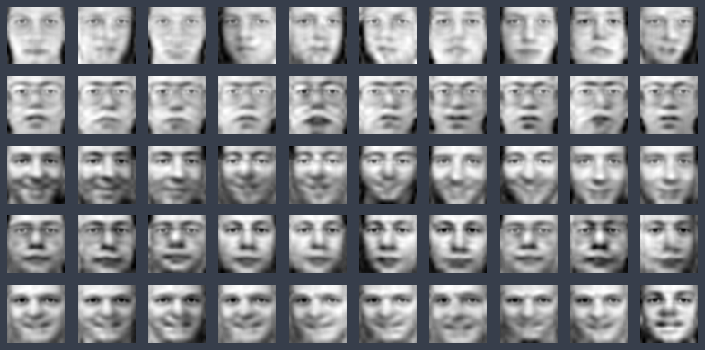

In [142]:
T, S1, U1 = trunc(S, U, dim, su=True)
show_gallery(T+mean_face, 5)

#### Спроецируем лица двумя способами
##### p0 = tensor x_1 U(1)^T x_2 U(2)^T
##### p1 = S x_0 U(0)

In [124]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

p0 = gmul(T, [eye(400), U1[1].T, U1[2].T])
p1 = kmul(S1, U1[0], 0)
print(shape(p0), shape(p1))

(400, 12, 11) (400, 12, 11)


#### Убедимся, что в результате получаются одинаковые проекции

In [141]:
k = np.random.choice(400,1)

print(p0[k,:3,:3])
print()
print(p1[k,:3,:3])
print()
print(norm(p0-p1))

[[[-9.81136803  1.855189    1.78026768]
  [-1.40528634 -0.75893009  1.15220308]
  [ 1.62576628 -0.49463323  0.48944125]]]

[[[-9.81136799  1.85518897  1.78026772]
  [-1.40528631 -0.75893009  1.15220308]
  [ 1.62576628 -0.49463326  0.48944128]]]

7.02517614515e-06


In [126]:
clf = LogisticRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
score = average(cross_val_score(clf, [np.concatenate(p) for p in p0], y, cv=cv, scoring='accuracy'))
print(round(score,4)*100,'%')

96.38 %


In [127]:
clf = LogisticRegression()
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
score = average(cross_val_score(clf, [np.concatenate(p) for p in p1], y, cv=cv, scoring='accuracy'))
print(round(score,4)*100,'%')

96.38 %


### Тензор-ядро и сингулярные значения развёрток
Зададимся теперь вопросом: какова связь между сингулярными значениями развёрток и ядром тензора?
Рассмотрим оставленные сингулярные значения и оставленные элементы ядра:

In [263]:
s1 = [s[i][:dim[i]] for i in range(3)]
S1 = S[[slice(0,dim[i]) for i in range(3)]]

print(norm(s1[0]))
print(norm(s1[1]))
print(norm(s1[2]))
print(norm(S1))
# Совпадение?

168.579
168.724
168.957
160.619


In [264]:
print(norm(s[0]))
print(norm(s[1]))
print(norm(s[2]))
print(norm(S))
# Не думаю!

177.674
177.674
177.674
177.674


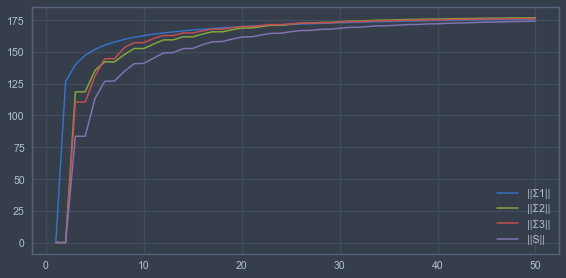

In [267]:
# Отобразим сей факт на графике
figure()
norms = []
max_per_cent = 50
for per_cent in range(max_per_cent):
    d = vectorize(int)((array((400,64,64))*per_cent/100.0))
    s1 = [s[i][:d[i]] for i in range(3)]
    S1 = S[[slice(0,d[i]) for i in range(3)]]
    norms += [[norm(s1[0]), norm(s1[1]), norm(s1[2]), norm(S1)]]
for n in array(norms).T:
    plot(range(1, max_per_cent+1), n)
legend(['||Σ1||', '||Σ2||', '||Σ3||', '||S||'])
show()

# Напомним, Σ1 соответствует фотографиям (выделяются типажи), полный ранг 400;
# Σ2 и Σ3 соответствуют строкам и столбцам, полные ранги – 64 и 64;
# S – ядро тензора всей выборки в совокупности.

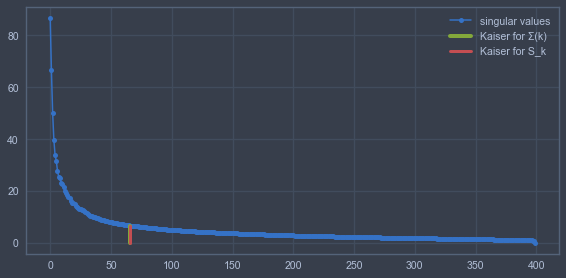

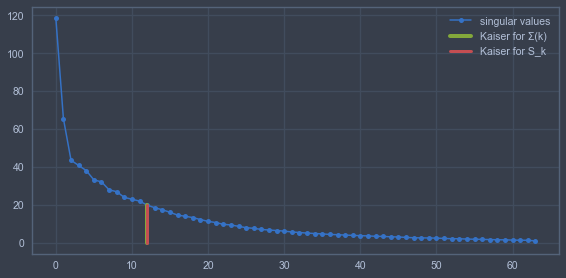

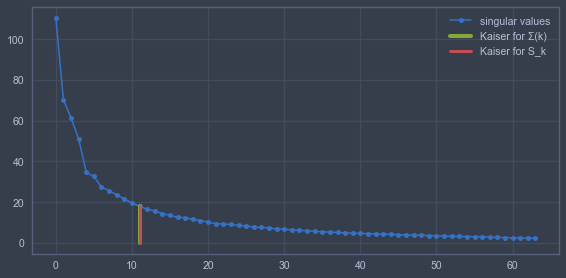

In [301]:
alpha = 0.9

rank = shape(S)
S_n1 = array([norm(S[d,:,:]) for d in range(rank[0])])
S_n2 = array([norm(S[:,d,:]) for d in range(rank[1])])
S_n3 = array([norm(S[:,:,d]) for d in range(rank[2])])
dim_n = [PCN['Kaiser'](S_n1, alpha),
         PCN['Kaiser'](S_n2, alpha),
         PCN['Kaiser'](S_n3, alpha)]

dim = []
for sigma in s:
    k = PCN['Kaiser'](sigma, alpha)
    dim += [k]

for i in range(3):
    figure()
    plot(s[i], '-o', markersize=5)
    plot([dim[i],dim[i]], [0, s[i][dim[i]]], 'g', linewidth=4)
    plot([dim_n[i],dim_n[i]], [0, s[i][dim_n[i]]], 'r', linewidth=3)
    legend(['singular values', 'Kaiser for Σ(k)', 'Kaiser for S_k'])
show()

# Результат совпадает!

# Weizmann FaceBase dataset

In [529]:
import glob
import collections
from PIL import Image


file_names = []
for d in glob.glob('data/weizmann-facebase/*.png'): file_names += [d[23:-4]]
labels = []
for fn in file_names: labels += [fn.split('-')]
f = [sort(list(set([l[i] for l in labels]))) for i in range(4)]
features = []
for l in labels:
    features += [[np.where(f[i]==l[i])[0][0] for i in range(4)]]

size = 512,352
a = 0.35
X = []
for g in features:
    file_name = '%s-%s-%s-%s' % (f[0][g[0]], f[1][g[1]], f[2][g[2]], f[3][g[3]])
    img = Image.open('data/weizmann-facebase/' + file_name + '.png').convert('L')
    img.thumbnail([int(a*size[1]), int(a*size[0])], Image.ANTIALIAS)
    h, w = int(0.15*a*size[0]), int(0.12*a*size[1])
    X += [array(img)[2*h:-h,w:-w]]
    
X = array(X)
print(shape(X))

(1260, 100, 95)


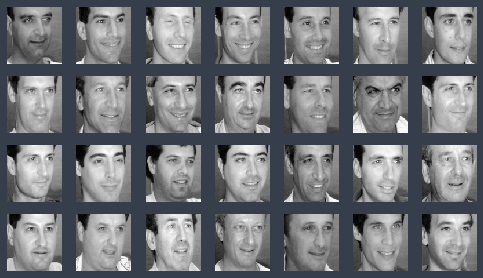

In [548]:
r = np.random.choice(45, 1)[0]
subset = array([X[i] for i in range(1260) if i%45==r])
show_gallery(subset, 4, 7)

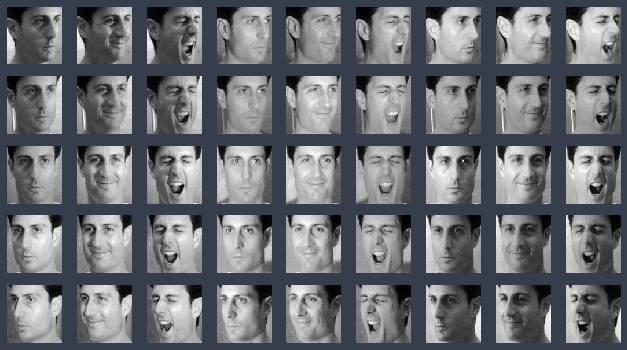

In [542]:
k = np.random.choice(28, 1)[0]
subset = array([X[i] for i in range(1260) if features[i][0]==k])
show_gallery(subset, 5, 9)

#### Как бороться с пропусками?
Заполним пропуски усреднённым лицом

(28, 5, 3, 3, 100, 95)
11970000


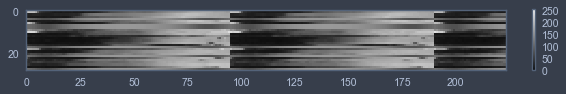

(28, 427500) people


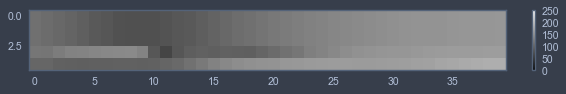

(5, 2394000) pose variations


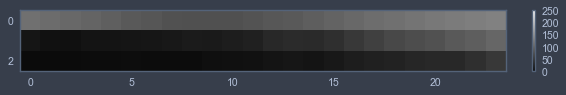

(3, 3990000) illuminations


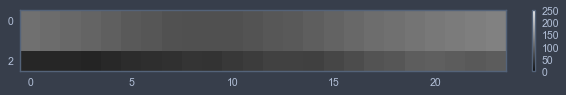

(3, 3990000) expressions


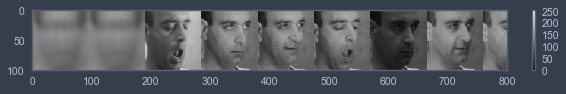

(100, 119700) rows


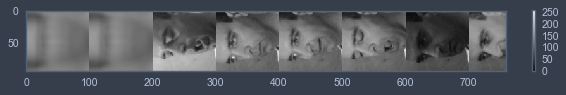

(95, 126000) columns


In [1013]:
import yt

X0, X1, features0, features1 = train_test_split(X, features, test_size=0.2, 
                                                random_state=int(np.random.random()*1260))
mean0 = sum(X0, axis=0)/len(X0)
T0 = tensoring(X0-mean0, features0)
print(shape(T0))
n_pix = product(shape(T0))
print(n_pix) # около 12 млн. значений хранится в исходном тензоре!

flattens = array([flat(T0+mean0,k) for k in range(len(shape(T)))])

for flatten,name in zip(flattens,['people', 'pose variations', 
                                  'illuminations', 'expressions', 
                                  'rows', 'columns']):
    figure()
    imshow(flatten[:,:8*len(flatten)], cmap=get_cmap('gray')).set_clim(vmin=0, vmax=255)
    grid(False)
    colorbar(fraction=0.006, pad=0.05)
    show()
    print(shape(flatten),name)

In [1014]:
S0,U0 = hosvd(T0)

In [1017]:
alpha = 0.95
Sn = [array([norm(flaxis(S0,i)[j]) for j in range(shape(S0)[i])]) for i in range(len(shape(S0)))]
dim = [PCN['Kaiser'](sn, alpha) for sn in Sn]
print(dim)

T0tr = trunc(S0, U0, dim)

[23, 4, 2, 2, 12, 14]


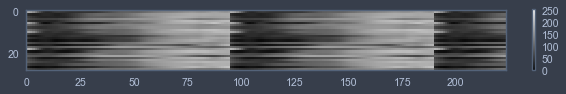

(28, 427500) people


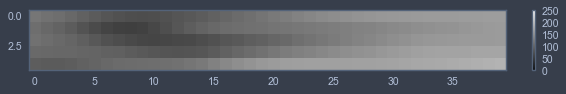

(5, 2394000) pose variations


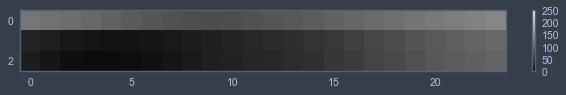

(3, 3990000) illuminations


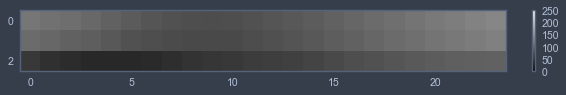

(3, 3990000) expressions


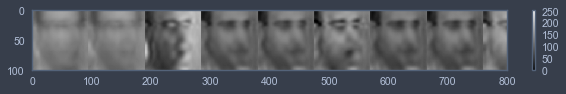

(100, 119700) rows


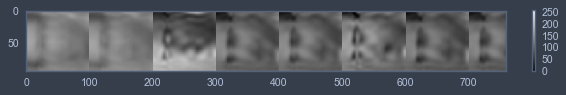

(95, 126000) columns


In [1018]:
flattens = array([flat(T0tr+mean0,k) for k in range(len(shape(T0tr)))])

for flatten,name in zip(flattens,['people', 'pose variations', 
                                  'illuminations', 'expressions', 
                                  'rows', 'columns']):
    figure()
    imshow(flatten[:,:8*len(flatten)], cmap=get_cmap('gray')).set_clim(vmin=0, vmax=255)
    grid(False)
    colorbar(fraction=0.006, pad=0.05)
    show()
    print(shape(flatten),name)

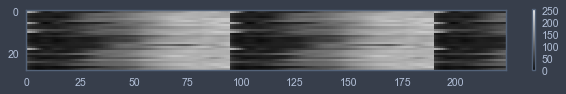

(28, 427500) people


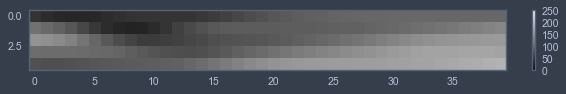

(5, 2394000) pose variations


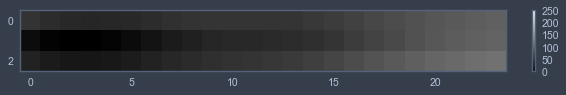

(3, 3990000) illuminations


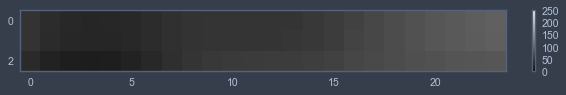

(3, 3990000) expressions


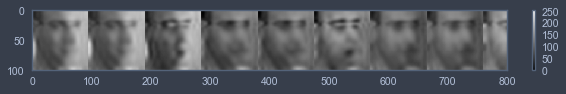

(100, 119700) rows


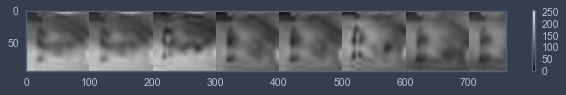

(95, 126000) columns


In [1019]:
mean = sum(X, axis=0)/len(X)
T = tensoring(X-mean, features)
S,U = hosvd(T)
Ttr = trunc(S,U,dim)

flattens = array([flat(Ttr+mean,k) for k in range(len(shape(Ttr)))])
for flatten,name in zip(flattens,['people', 'pose variations', 
                                  'illuminations', 'expressions', 
                                  'rows', 'columns']):
    figure()
    imshow(flatten[:,:8*len(flatten)], cmap=get_cmap('gray')).set_clim(vmin=0, vmax=255)
    grid(False)
    colorbar(fraction=0.006, pad=0.05)
    show()
    print(shape(flatten),name)

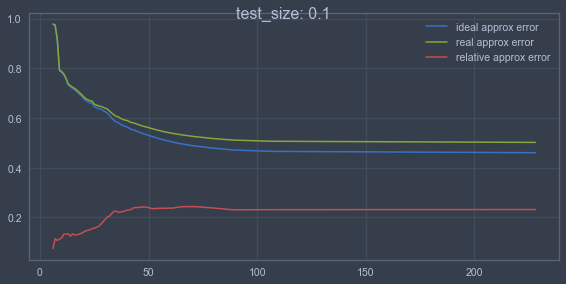

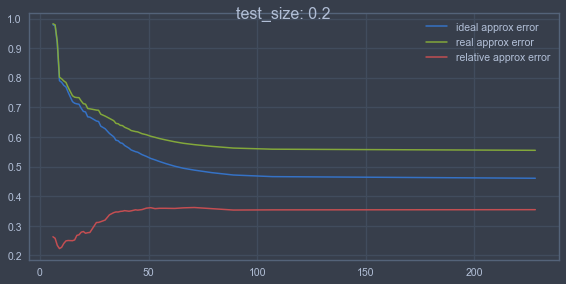

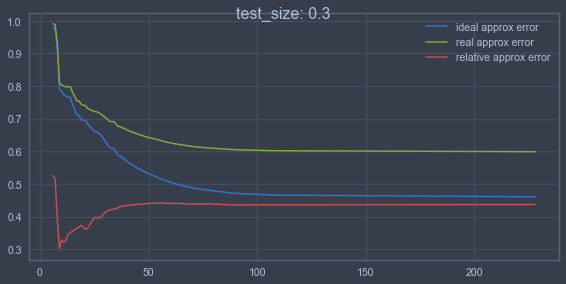

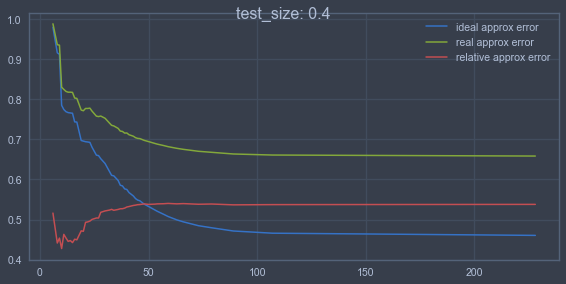

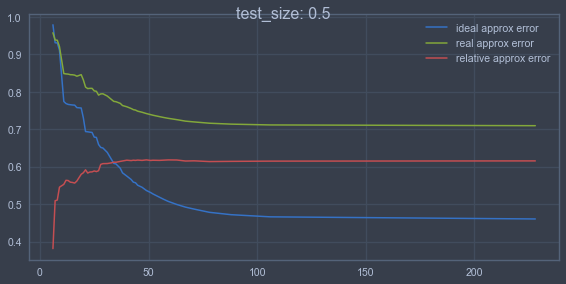

In [1062]:
h = 100
points = log((exp(1)-1)*array(range(5,h+1))/h+1)

for test_size in [.1, .2, .3, .4, .5]:
    X0, X1, features0, features1 = train_test_split(X, features, test_size=test_size, 
                                                random_state=int(np.random.random()*1260))
    mean0 = sum(X0, axis=0)/len(X0)
    T0 = tensoring(X0-mean0, features0)
    S0,U0 = hosvd(T0)
    
    error0 = []
    error1 = []
    error2 = []
    n_comp = []
    for alpha in points:
        Sn = [array([norm(flaxis(S0,i)[j]) for j in range(shape(S0)[i])]) for i in range(len(shape(S0)))]
        dim = [PCN['Kaiser'](sn, alpha) for sn in Sn]
        n_comp += [sum(dim)]

        T0tr = trunc(S0, U0, dim)
        Ttr = trunc(S, U, dim)
        error0 += [norm(Ttr-T0tr)/norm(Ttr)]
        error1 += [norm(T-Ttr)/norm(T)]
        error2 += [norm(T-T0tr)/norm(T)]
        
    figure()
    suptitle('test_size: ' + str(test_size), fontsize=16)
    plot(n_comp, error1, label='ideal approx error')
    plot(n_comp, error2, label='real approx error')
    plot(n_comp, error0, label='relative approx error')
    legend()
    show()

In [1089]:
Sn = [array([norm(flaxis(S,i)[j]) for j in range(shape(S)[i])]) for i in range(len(shape(S)))]
dim = [PCN['Kaiser'](sn, 0.98) for sn in Sn]
print(sum(dim))

75


In [1090]:
print([PCN['Kaiser'](sn, 0.98) for sn in Sn]) 
# Ранг тензора в таком случае таков:

[24, 4, 2, 2, 20, 23]


# TensorFaces
##### http://web.cs.ucla.edu/~dt/papers/eccv02/eccv02.pdf 
##### http://web.cs.ucla.edu/~dt/papers/icpr02/icpr02.pdf

In [ ]:
class TensorFaces(object):
    transform_gallery = lambda self, faces: [self.transform(f) for f in faces]
    def transform(self, face): 
        return self.A[:,:self.dim].T@self.concatenate(face)
        
    def reconstruct(self, project): 
        return reshape(self.A[:,:self.dim]@project,(self.n_rows,self.n_cols))
    
    approx = lambda self, face: self.reconstruct(self.transform(face))
    
    def __init__(self, X, features, vectorization=False):
        '''Class initialization
        
        Args:
            X[k,m,n]: set of k images m*n pixels each
            features[k,n1,...,nt]: t features of k images'''
        
        # 1. Vectorization
        r = shape(X)
        if vectorization:
            F = reshape(X,[r[0],prod(r[1:])])
        else:
            F = reshape(X,r)
        self.rank = [r[0]]+list(r[1:])
        
        # 2. Tensoring
        tensor = zeros(rank)
        
        # 3. HOSVD
        '''High-Ordered Singular Value Decomposition'''
        # A = S x1 U1 x2 U2 ... xN UN
        N = len(shape(tensor))
        # Тензор A ранга I1 x I2 x...x IN
        # Тензор-матрица для k-ого измерения A(k) = Ik x (I1*...*Ik-1*Ik+1*...*IN)
        A = [flat(tensor, k) for k in range(N)]
        # A(k) = Uk*Σk*Vk, сохраняем Uk
        U = [linalg.svd(A[k], full_matrices=False)[0] for k in range(N)]
        # Тензор-ядро S = A x1 U1^T x2 U2^T ... xN UN^T
        S = gmul(tensor, [transpose(u) for u in U])
        return (S,U)
        
        # 2. PCA
        if self.vec:
            # 2a. 1DPCA
            # 2a.1. Vectorization
            V = array([self.concatenate(f) for f in F])
            # 2a.2. Decomposition
            if self.dec=='eig':
                # 2a.2a Spectral decomposition
                Cov = V.T @ V
                l1, v = np.linalg.eigh(Cov)
                self.A = v.T[::-1,...][:k].T
                self.sigma1 = vectorize(sqrt)(l1[::-1,...][:k])
            elif self.dec=='svd':
                # 2a.2b. Singular value decomposition
                u, self.sigma1, v = np.linalg.svd(V, full_matrices=False)
                self.A = v.T
        else:
            # 2b. 2DPCA
            # 2b.1. Decomposition
            if self.dec=='eig':
                # 2b.1a. Spectral decompositions
                Cov_rows = sum([face @ face.T for face in F], axis=0)
                Cov_cols = sum([face.T @ face for face in F], axis=0)
                l1, v1 = np.linalg.eigh(Cov_rows)
                l2, v2 = np.linalg.eigh(Cov_cols)
                self.A = v1.T[::-1,...].T
                self.B = v2.T[::-1,...].T
                self.sigma1 = vectorize(sqrt)(l1[::-1,...])
                self.sigma2 = vectorize(sqrt)(l2[::-1,...])
            elif self.dec=='svd':
                # 2b.1b. Singular value decompositions
                F_rows = hstack(F)
                F_cols = vstack(F).T
                u1, self.sigma1, v1 = np.linalg.svd(F_rows, full_matrices=False)
                u2, self.sigma2, v2 = np.linalg.svd(F_cols, full_matrices=False)
                self.A = u1
                self.B = u2
        
        # 3. Low-rank approximation
        self.trunc()
        print(self.dim)
        
    def trunc(self, method='Brocken Stick', param=0.95, message=False):
        '''Rang truncation
        
        Args:
            method (string): how to find number of principal components?
            param (float/int): some parameter for this method'''
        if self.vec:
            self.dim = PCN[method](self.sigma1, param)
        else:
            if type(param) in [int, float]:
                param = (param, param)
            self.dim = (PCN[method](self.sigma1, param[0]), PCN[method](self.sigma2, param[1]))
        if message:
            print(self.dim)
        return self